In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import mu, get_velocity_profile, boxcarsmoothtrend, oh_to_12pluslog
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
reference = vice.output("../outputs/constant/vgas-0")

In [3]:
outputs = [
    # "../outputs/constant/vgas-0p5",
    # "../outputs/constant/vgas-1",
    # "../outputs/constant/vgas-1p5"
    "../outputs/potential-well-deepening/gamma0p1",
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/potential-well-deepening/gamma0p3"
    # "../outputs/angular-momentum-dilution/betaphiin0p8",
    # "../outputs/angular-momentum-dilution/betaphiin0p7",
    # "../outputs/angular-momentum-dilution/betaphiin0p6"
]
outputs = [vice.output(name) for name in outputs]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_38887/2851037503.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


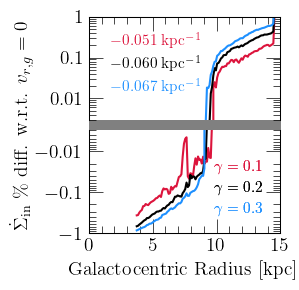

In [6]:
# LOGFACTOR = 3
COLORS = ["crimson", "black", "dodgerblue"]
# LABELS = [r"$v_{r,g} = %.1f$ km/s" % (v) for v in [-0.5, -1, -1.5]]
# GRAD = [-0.052, -0.063, -0.069]
LABELS = [r"$\gamma = 0.1$", r"$\gamma = 0.2$", r"$\gamma = 0.3$"]
GRAD = [-0.051, -0.060, -0.067]
# LABELS = [r"$\beta_{\phi,\text{in}} = %g$" % (b) for b in [0.8, 0.7, 0.6]]
# GRAD = [-0.061, -0.072, -0.081]

fig = plt.figure(figsize = (3, 3))
# ax = fig.add_subplot(111)
# ax.set_xlabel(r"Galactocentric Radius [kpc]")
# ax.set_ylabel(r"$\dot \Sigma_\text{in} / \dot \Sigma_\text{in}(v_{r,g} = 0)$ [$\times$ 10$^{-%d}$]" % (LOGFACTOR))
# ax.set_xlim([0, 15])
# ax.set_ylim([-3, 3])
# ax.set_yticks([-2, 0, 2])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
for ax in [ax1, ax2]:
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(fsf("%g"))
# ax1.set_yscale("log")
# ax2.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible = False)
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
dummy = fig.add_axes([0.1, 0.1, 0.8, 0.8], xticks = [], yticks = [], zorder = -1000)
dummy.spines["left"].set_visible(False)
dummy.spines["right"].set_visible(False)
# dummy.set_ylabel(r"$\dot \Sigma_\text{in} / \dot \Sigma_\text{in}(v_{r,g} = 0)$", labelpad = 40)
dummy.set_ylabel(r"$\dot \Sigma_\text{in}$ \% diff. w.r.t. $v_{r,g} = 0$", labelpad = 40)
ax1.set_xlim([0, 15])
# ax1.set_ylim([3.e-5, 3.e-2]) # Constant
# ax2.set_ylim([3.e-4, 3.e-1])
ax1.set_ylim([3.e-3, 1.e0]) # PWD
ax2.set_ylim([3.e-3, 1.e0])
dummy.set_xlim([0, 15])
dummy.set_ylim([0, 1])
kwargs = {
    "axis": "x",
    "which": "both",
    "bottom": False
}
ax1.tick_params(**kwargs)
kwargs["bottom"] = True
kwargs["top"] = False
ax2.tick_params(**kwargs)
ax1.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)

def ifr_snapshot(output, lookback, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    n_zones = len(output.zones.keys())
    radii = [zone_width * (i + 0.5) for i in range(n_zones)]
    ifr = [output.zones["zone%d" % (i)].history["ifr"][idx] for i in range(n_zones)]
    return [radii, ifr]

def plot_diff(ax_pos, ax_neg, output, reference, lookback, zone_width = 0.1, **kwargs):
    # print('a')
    radii, ifr = ifr_snapshot(output, lookback, zone_width = zone_width)
    # print('b')
    _, ref_ifr = ifr_snapshot(reference, lookback, zone_width = zone_width)
    # print('c')
    yvals = [a / b - 1 if b else float("nan") for a, b in zip(ifr, ref_ifr)]
    yvals = boxcarsmoothtrend(radii, yvals, window = 10)
    ax_pos.plot(radii, yvals, **kwargs)
    if kwargs["label"] is not None: kwargs["label"] = None
    ax_neg.plot(radii, [-y for y in yvals], **kwargs)

lines = []
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
        # "label": r"$\nabla = %.3f$ kpc$^{-1}$" % (GRAD[i])
    }
    lines.append(
        ax2.plot([1, 2], [1, 2], **kwargs)[0]
    )
kwargs = {
    "loc": mpl_loc("lower right"),
    "bbox_to_anchor": (0.98, 0.02),
    "handlelength": 0,
    "fontsize": 11
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)
ax2.add_artist(leg)
for line in lines: line.remove()

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        # "label": LABELS[i]
        "label": r"$%.3f$ kpc$^{-1}$" % (GRAD[i])
        # "label": r"%s; $\nabla = %.3f$ kpc$^{-1}$" % (LABELS[i], GRAD[i])
    }
    plot_diff(ax1, ax2, outputs[i], reference, 0, **kwargs)

# ax.axhline(0, c = named_colors()["black"], linestyle = ":")

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.02, 0.98),
    "handlelength": 0,
    "fontsize": 11
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

h = 0.1
plt.tight_layout()
negative_log(ax2)
plt.subplots_adjust(left = 0.28, hspace = h)
dummy.fill_between(dummy.get_xlim(), 2 * [0.5 - h / 2], 2 * [0.5 + h / 2],
    color = named_colors()["grey"])
dummy.set_position([
    ax1.get_position().x0,
    ax2.get_position().y0,
    ax1.get_position().x1 - ax1.get_position().x0,
    ax1.get_position().y1 - ax2.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./sfr-ifr/ifrshift-constant.%s" % (ext), **kwargs)
    plt.savefig("./sfr-ifr/ifrshift-pwd.%s" % (ext), **kwargs)
    # plt.savefig("./sfr-ifr/ifrshift-amd.%s" % (ext), **kwargs)
plt.show()

In [14]:
outputs = [
    "../outputs/potential-well-deepening/gamma0p1",
    "../outputs/potential-well-deepening/gamma0p2",
    # "../outputs/constant/vgas-0",
    "../outputs/potential-well-deepening/gamma0p3"
]
outputs = [vice.output(name) for name in outputs]

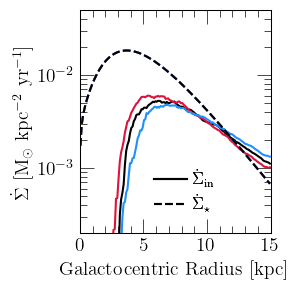

In [16]:
# COLORS = ["black", "crimson", "lime", "royalblue"]
# COLORS = ["black", "crimson", "dodgerblue"]
COLORS = ["crimson", "black", "dodgerblue"]
LABELS = [
    # r"$v_{r,g} = 0$",
    r"$\gamma = 0.1$",
    r"$\gamma = 0.2$",
    r"$\gamma = 0.3$"
    # r"$\beta_{\phi,\text{in}} = 0.8$",
    # r"$\beta_{\phi,\text{in}} = 0.7$",
    # r"$\beta_{\phi,\text{in}} = 0.6$"
]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
# res = fig.add_axes([0.1, 0.1, 0.8, 0.1], sharex = ax)
# plt.setp(ax.get_xticklabels(), visible = False)
# res.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot \Sigma$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
# res.set_ylabel(r"$\frac{\partial \ln \dot \Sigma}{\partial R}$ [kpc$^{-1}$]")
ax.set_yscale("log")
ax.set_xlim([0, 15])
ax.set_ylim([2.e-4, 0.05])
# res.set_ylim([-0.5, 0.5])
# res.set_yticks([-0.2, 0, 0.2])

# def plot_profiles(ax, res, output, lookback, zone_width = 0.1, **kwargs):
def plot_profiles(ax, output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    # n_zones = len(output.zones.keys())
    n_zones = 150
    radii = [zone_width * (i + 0.5) for i in range(n_zones)]
    sigma_ifr = []
    sigma_sfr = []
    dlnsigmaifr_dr = []
    dlnsigmasfr_dr = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width)**2 - radii[i]**2)
        zone = output.zones["zone%d" % (i)]
        sigma_ifr.append(zone.history["ifr"][idx] / area)
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        # if i < len(radii) - 1:
        #     n_area = np.pi * ((radii[i + 1] + zone_width)**2 - radii[i + 1]**2)
        #     n_zone = output.zones["zone%d" % (i + 1)]
        #     n_sigma_ifr = n_zone.history["ifr"][idx] / n_area
        #     n_sigma_sfr = n_zone.history["sfr"][idx] / n_area
        #     if sigma_ifr[-1]:
        #         if sigma_ifr[-1] < 0: print(sigma_ifr[-1])
        #         dlnsigmaifr_dr.append(
        #             (n_sigma_ifr - sigma_ifr[-1]) / (sigma_ifr[-1] * zone_width)
        #         )
        #     else:
        #         dlnsigmaifr_dr.append(float("nan"))
        #     if sigma_sfr[-1]:
        #         dlnsigmasfr_dr.append(
        #             (n_sigma_sfr - sigma_sfr[-1]) / (sigma_sfr[-1] * zone_width)
        #         )
        #     else:
        #         dlnsigmasfr_dr.append(float("nan"))
        # else: pass
    sigma_ifr = boxcarsmoothtrend(radii, sigma_ifr, window = 5)
    # dlnsigmaifr_dr = boxcarsmoothtrend(radii[:-1], dlnsigmaifr_dr, window = 10)
    if "c" in kwargs.keys() and kwargs["c"] == named_colors()["black"]: kwargs["zorder"] = -1000
    ax.plot(radii, sigma_ifr, linestyle = "-", **kwargs)
    # res.plot(radii[:-1], dlnsigmaifr_dr, **kwargs)
    if "c" in kwargs.keys() and kwargs["c"] == named_colors()["black"]: kwargs["zorder"] = 1000
    if "label" in kwargs.keys() and kwargs["label"] is not None: kwargs["label"] = None
    ax.plot(radii, sigma_sfr, linestyle = "--", **kwargs)
    # res.plot(radii[:-1], dlnsigmasfr_dr, linestyle = "--", **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "-",
    "label": r"$\dot \Sigma_\text{in}$"
}
line1 = ax.plot([1, 2], [1, 2], **kwargs)[0]
kwargs["linestyle"] = "--"
kwargs["label"] = r"$\dot \Sigma_\star$"
line2 = ax.plot([1, 2], [1, 2], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("lower right"),
    "bbox_to_anchor": (0.78, 0.02),
    # "handlelength": 1.5,
    "fontsize": 12
}
leg = ax.legend(**kwargs)
ax.add_artist(leg)
line1.remove()
line2.remove()

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    # plot_profiles(ax, res, outputs[i], 0, **kwargs)
    plot_profiles(ax, outputs[i], 0, **kwargs)

# kwargs = {
#     "loc": mpl_loc("lower right"),
#     "bbox_to_anchor": (0.68, 0.02),
#     "handlelength": 0,
#     "fontsize": 11,
#     "ncol": 1,
#     "columnspacing": 1
# }
# leg = ax.legend(**kwargs)
# fancy_legend(leg, COLORS)

# reswidth = 0.35
plt.tight_layout()
# res.set_position([
#     ax.get_position().x0,
#     ax.get_position().y0,
#     ax.get_position().x1 - ax.get_position().x0,
#     reswidth
# ])
# ax.set_position([
#     ax.get_position().x0,
#     ax.get_position().y0 + reswidth,
#     ax.get_position().x1 - ax.get_position().x0,
#     ax.get_position().y1 - ax.get_position().y0 - reswidth
# ])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./sfr-ifr/sfr-ifr-profiles-pwd.%s" % (ext), **kwargs)
plt.show()